<a href="https://colab.research.google.com/github/leandro-driguez/Machine-Learning-Techniques/blob/dev/Taller_2/others/Taller_2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/hectormelo/Machine-Learning-Techniques/main/Banner.png" ><br>
# Machine Learning Techniques - MISIS4219

Primer semestre - 2024


# **Imports**

In [11]:
import os
import pywt
import mahotas
import requests
import numpy as np
from PIL import Image
import xgboost as xgb
from io import BytesIO
from scipy import stats
import mahotas.features
from zipfile import ZipFile
from joblib import dump, load
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import GridSearchCV
from skimage.feature import local_binary_pattern
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# 1. **Exploración de Datos**

## Descargando y Descomprimiendo el Conjunto de Datos

Antes de que podamos proceder con la carga y el procesamiento de las imágenes, necesitamos obtener el conjunto de datos. Esta sección del cuaderno está dedicada a descargar un archivo ZIP que contiene el conjunto de datos EuroSAT desde una URL de repositorio de GitHub especificada y luego descomprimirlo en un directorio designado. Este paso es crucial para hacer el conjunto de datos accesible para tareas de carga y análisis subsiguientes.

In [2]:
# URL of the ZIP file in the GitHub repository
url = 'https://github.com/hectormelo/Machine-Learning-Techniques/raw/main/Lab_2/EuroSAT3.zip'

# Download the ZIP file
response = requests.get(url)
if response.status_code == 200:
    zip_content = response.content
    # Unzip the content in memory
    with ZipFile(BytesIO(zip_content)) as zip_file:
        # Specify the directory where you want to unzip
        zip_file.extractall("./EuroSAT3")
    print("File successfully unzipped.")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

File successfully unzipped.


## Cargando y Etiquetando Imágenes

En esta sección, cargaremos imágenes de diferentes categorías para preparar nuestros datos de entrenamiento. Definimos un conjunto de categorías que corresponden a los nombres de las carpetas donde se almacenan nuestras imágenes. Para cada categoría, cargamos las imágenes, las normalizamos (como se describió en el paso anterior) y asignamos una etiqueta numérica a cada imagen. Esto nos permitirá entrenar un modelo de clasificación de imágenes más adelante en el cuaderno.

El proceso es el siguiente:

1. Definir las categorías de imágenes que queremos cargar.
2. Preparar dos listas: una para almacenar las imágenes y otra para las etiquetas.
3. Iterar sobre cada categoría, cargar las imágenes de esa categoría y asignar una etiqueta numérica a cada imagen basada en su categoría.
4. Convertir las listas de imágenes y etiquetas en arreglos de NumPy para facilitar su manipulación en pasos posteriores de procesamiento o entrenamiento de modelos.

In [3]:
def load_images(folder):
    """
    Load and normalize images from a specified folder.

    This function iterates over all files in the given folder, assuming they are images.
    Each image is converted to an RGB array and normalized to have values between 0 and 1.

    Args:
        folder (str): The path to the folder containing the images.

    Returns:
        list: A list of normalized images represented as numpy arrays.
    """
    
    # Initialize an empty list to store the normalized images
    images = []
    
    # Iterate over every file in the specified folder
    for filename in os.listdir(folder):
        # Construct the full path to the file
        image_path = os.path.join(folder, filename)
        
        try:
            # Open the image, convert it to RGB to ensure consistency, and convert to numpy array
            with Image.open(image_path) as image:
                image = np.array(image.convert("RGB"))
        except Exception as e:
            print(f"Error loading image {filename}: {e}")
            continue
        
        # Normalize the image data to 0-1 range
        normalized_image = image / 255.0
        
        # Append the normalized image to our list
        images.append(normalized_image)
    
    return images

In [4]:
# List of categories corresponding to the folder names of images
categories = ['Forest', 'Industrial', 'PermanentCrop', 'Residential', 'River']
base_path = './EuroSAT3/'  # Base path where the category folders are located

# Initialize lists to store all images and labels
all_images = []
all_labels = []

# Iterate over each category to load the images
for label, category in enumerate(categories):
    # Create the full path to the current category's folder
    folder = os.path.join(base_path, category)
    # Load all images from the current folder
    category_images = load_images(folder)
    # Add the loaded images to the general image list
    all_images.extend(category_images)
    # Assign a corresponding label to each loaded image
    all_labels.extend([label] * len(category_images))

# Convert the lists of images and labels into NumPy arrays
all_images_np = np.array(all_images)
all_labels_np = np.array(all_labels)

## Dividiendo el Conjunto de Datos en Entrenamiento y Pruebas

Después de cargar y preprocesar nuestras imágenes y sus correspondientes etiquetas, el siguiente paso crucial es dividir el conjunto de datos en conjuntos de entrenamiento y pruebas. Esto nos permite entrenar nuestro modelo en una porción de los datos (conjunto de entrenamiento) y luego evaluar su rendimiento en datos no vistos (conjunto de pruebas). Utilizando la función train_test_split de sklearn.model_selection, podemos fácilmente particionar el conjunto de datos de acuerdo a esto. Asignaremos el 80% de los datos para el entrenamiento y reservaremos el 20% para las pruebas. Adicionalmente, establecer un random_state asegura que nuestros resultados sean reproducibles.

In [5]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_images_np, all_labels_np, test_size=0.2, random_state=42)

# Displaying the shapes of the training and testing sets
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (3000, 64, 64, 3)
y_train shape: (3000,)
X_test shape: (750, 64, 64, 3)
y_test shape: (750,)


## Visualizando la Distribución de Clases

Después de dividir nuestro conjunto de datos en conjuntos de entrenamiento y prueba, es importante examinar la distribución de clases dentro de nuestro conjunto de entrenamiento. Este paso nos ayuda a comprender el equilibrio (o desequilibrio) entre las diferentes clases, lo cual puede informarnos sobre posibles sesgos en nuestro conjunto de datos y puede influir en nuestra elección de métricas de evaluación de modelos o en la necesidad de técnicas de remuestreo. A continuación, utilizaremos un histograma para visualizar la distribución de clases en nuestros datos de entrenamiento.

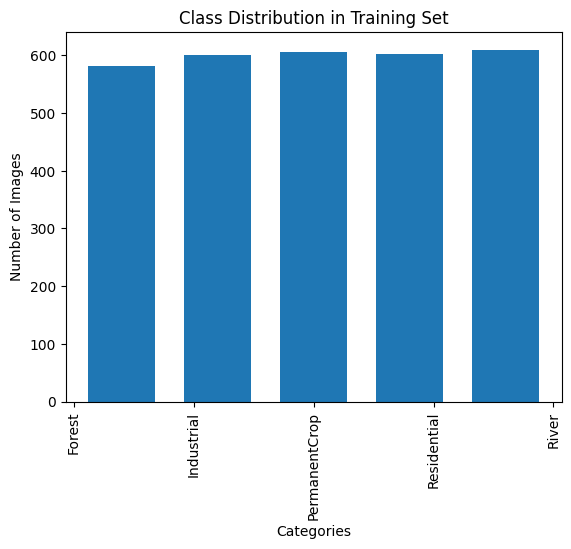

In [6]:
# Visualize the distribution of classes
plt.hist(y_train, bins=len(categories), rwidth=0.7)  # Adjust the number of bins to match the number of categories
plt.xticks(ticks=range(len(categories)), labels=categories, rotation='vertical')  # Label x-axis with category names
plt.title("Class Distribution in Training Set")  # Add a title for clarity
plt.xlabel("Categories")  # Label the x-axis
plt.ylabel("Number of Images")  # Label the y-axis
plt.show()

## Observando Imágenes Aleatorias del Conjunto de Entrenamiento

La inspección visual del conjunto de datos es un paso crucial para entender mejor los datos. Al seleccionar y mostrar aleatoriamente imágenes de nuestro conjunto de entrenamiento, podemos obtener una idea de la variedad y calidad de las imágenes de las que nuestro modelo aprenderá. Este paso también nos permite confirmar visualmente si las etiquetas están correctamente asignadas, identificando potencialmente cualquier anomalía o imágenes mal etiquetadas desde el principio. Vamos a mostrar algunas imágenes aleatorias junto con sus etiquetas para ver ejemplos de cada clase.

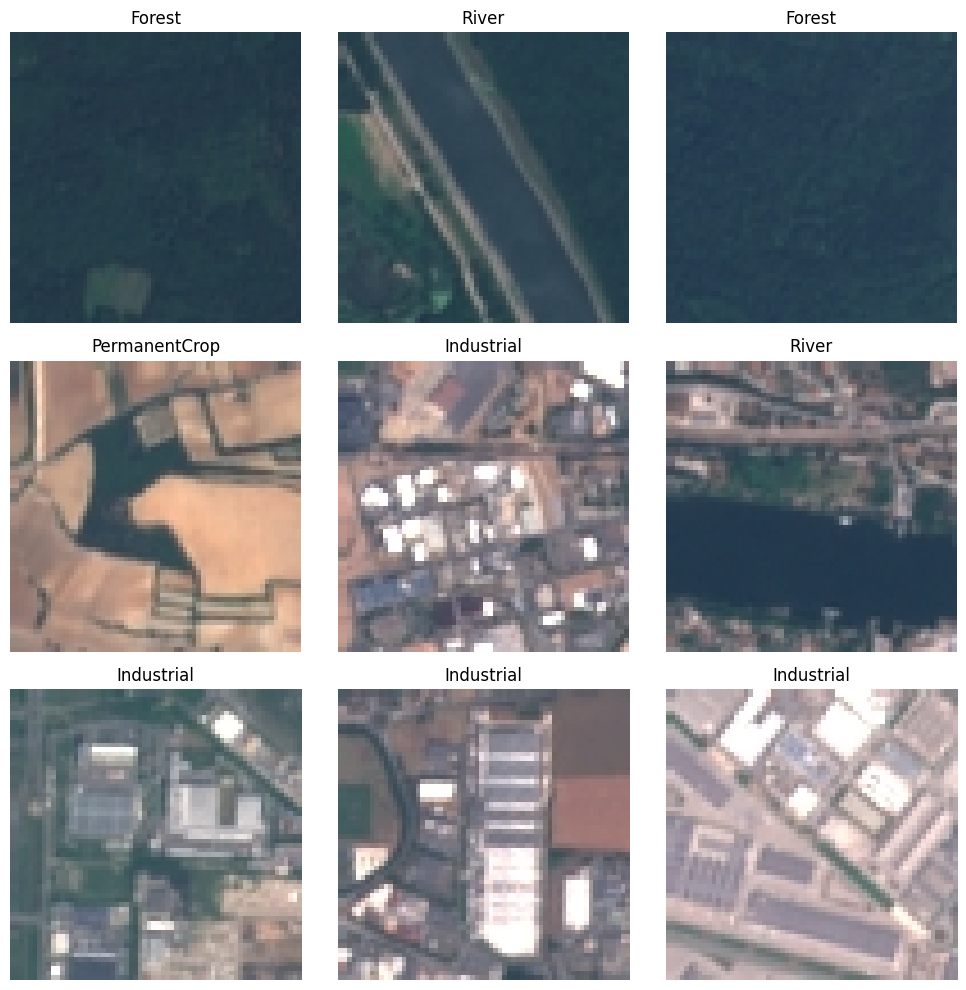

In [7]:
plt.figure(figsize=(10, 10))  # Set the figure size for better visibility

for i in range(9):  # Display 9 images
    plt.subplot(3, 3, i + 1)  # Arrange images in a 3x3 grid
    rnd_idx = np.random.randint(0, len(X_train))  # Select a random index
    plt.imshow(X_train[rnd_idx])  # Display the image at the random index
    plt.title(categories[y_train[rnd_idx]])  # Show the category label as the title
    plt.axis('off')  # Hide the axis for a cleaner look

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

# 2. **Preparación de Datos**

## Ingeniería de Características

Este segmento del notebook se enfoca en la extracción de múltiples tipos de características de las imágenes para preparar nuestros datos para el entrenamiento de modelos de aprendizaje automático. A continuación, se detalla el propósito y la relevancia de cada función:

- `extract_color_stats(image)`: Esta función extrae estadísticas básicas de color, como la media, desviación estándar, varianza, mediana, moda, valor mínimo y máximo, percentiles (25, 50, 75), sesgo, curtosis y rango de cada canal de color de la imagen. Estas estadísticas proporcionan una visión global de la distribución de intensidades de color en la imagen, lo cual puede ser muy relevante para identificar patrones relacionados con ciertas categorías de imágenes en tareas de clasificación o segmentación. Por ejemplo, en la clasificación de imágenes naturales, ciertas estadísticas de color podrían ayudar a distinguir entre imágenes de bosques y océanos.

- `extract_color_histogram(image, bins=32, channel_range=(0, 256))`: Calcula el histograma de color para cada canal de color, lo que proporciona una representación binaria de la distribución de intensidades de color en la imagen. Este tipo de característica es fundamental para entender la distribución general de los colores en la imagen y puede ser crucial para distinguir entre diferentes objetos o escenas que tienden a tener distribuciones de color característicos.

- `extract_haralick_features(image)`: Extrae características de textura de Haralick de la imagen convertida a escala de grises. Las características de Haralick, que incluyen aspectos como homogeneidad, contraste, correlación y otros, describen la textura de la imagen, lo cual es especialmente útil para clasificar imágenes basadas en patrones de textura o para identificar áreas dentro de una imagen que comparten propiedades texturales similares.

- `extract_lbp_features(image, P=8, R=1, method='uniform')`: Calcula el patrón binario local (LBP) de la imagen en escala de grises, un descriptor de textura que es robusto ante cambios en la iluminación. LBP es ampliamente usado para tareas de reconocimiento de texturas y rostros porque captura la estructura local de una imagen de manera eficaz. La relevancia de extraer LBP radica en su capacidad para representar detalles texturales finos que pueden ser determinantes en la clasificación o análisis de imágenes.

- `extract_fft_features(image)`: Aplica la transformada rápida de Fourier (FFT) a la imagen en escala de grises para extraer características basadas en los coeficientes de FFT, como la media y la desviación estándar de las magnitudes de los coeficientes. La FFT permite analizar la imagen en el dominio de la frecuencia, lo cual es útil para identificar patrones periódicos o para distinguir entre texturas basadas en la presencia de frecuencias altas o bajas.

- `extract_wavelet_features(image, mode='haar', level=1)`: Utiliza la transformada wavelet para descomponer la imagen en escala de grises en componentes de baja y alta frecuencia. Las características extraídas de los coeficientes de wavelet son útiles para capturar tanto la textura como la estructura a diferentes escalas, lo que puede ser crucial para aplicaciones como la detección de bordes, la clasificación de texturas y la compresión de imágenes.

- `preprocess_image(image)`: Esta función integra todas las características extraídas por las funciones anteriores en un solo vector de características para cada imagen. La relevancia de esta función radica en su capacidad para combinar múltiples tipos de información (color, textura, frecuencia) en una representación unificada de la imagen, lo que enriquece el conjunto de datos de entrada para los algoritmos de aprendizaje automático y puede mejorar significativamente el rendimiento de los modelos de clasificación o regresión.

La combinación de estas características proporciona una representación detallada y multifacética de las imágenes, aprovechando diferentes aspectos visuales que son esenciales para una amplia variedad de tareas de visión por computadora.

In [8]:
def extract_color_stats(image):
    """
    Extract basic color statistics from an image.

    Args:
        image (ndarray): The image array in RGB format.

    Returns:
        list: A list of statistical features for each color channel including mean,
        standard deviation, variance, median, mode, min, max, 25th percentile,
        50th percentile, 75th percentile, skewness, kurtosis, and range.
    """
    features = []

    for channel in range(image.shape[-1]):
        channel_data = image[:, :, channel].ravel()
        
        mean = np.mean(channel_data)
        std = np.std(channel_data)
        var = np.var(channel_data)
        median = np.median(channel_data)
        
        mode_result = stats.mode(channel_data)
        mode = mode_result.mode
        
        min_val = np.min(channel_data)
        max_val = np.max(channel_data)
        percentile_25 = np.percentile(channel_data, 25)
        percentile_50 = np.percentile(channel_data, 50)
        percentile_75 = np.percentile(channel_data, 75)
        skewness = stats.skew(channel_data)
        kurtosis = stats.kurtosis(channel_data)
        data_range = max_val - min_val
        
        features.extend([
            mean, std, var, median, mode, min_val, max_val,
            percentile_25, percentile_50, percentile_75,
            skewness, kurtosis, data_range
        ])

    return features

def extract_color_histogram(image, bins=32, channel_range=(0, 256)):
    """
    Extract a color histogram from an image.

    Args:
        image (ndarray): The image array in RGB format.
        bins (int): Number of histogram bins.
        channel_range (tuple): The range of values for each channel.

    Returns:
        ndarray: The concatenated histograms of all color channels.
    """
    histogram = [np.histogram(image[:, :, i], bins=bins, range=channel_range)[0] for i in range(image.shape[-1])]
    return np.concatenate(histogram)

def extract_haralick_features(image):
    """
    Extract Haralick texture features from an image.

    Args:
        image (ndarray): The image array in RGB format.

    Returns:
        ndarray: The mean Haralick features across the four directions.
    """
    gray_image = rgb2gray(image)
    gray_image = (gray_image * 255).astype('uint8')

    features = mahotas.features.haralick(gray_image).mean(axis=0)
    
    return features

def extract_lbp_features(image, P=8, R=1, method='uniform'):
    """
    Extract Local Binary Pattern (LBP) features from an image.

    Args:
        image (ndarray): The image array in RGB format.
        P (int): Number of circularly symmetric neighbour set points.
        R (float): Radius of circle.
        method (str): Method to extract LBP features.

    Returns:
        ndarray: The histogram of LBP features.
    """
    image_gray = rgb2gray(image)
    lbp = local_binary_pattern(image_gray, P=P, R=R, method=method)

    lbp_hist, _ = np.histogram(lbp, density=True, bins=np.arange(0, P + 3), range=(0, P + 2))
    return lbp_hist

def extract_fft_features(image):
    """
    Extract features from the magnitude spectrum of the image's FFT.

    Args:
        image (ndarray): The image array in RGB format.

    Returns:
        tuple: Mean and standard deviation of the FFT magnitude spectrum.
    """
    fft_coefs = np.fft.fft2(rgb2gray(image))
    fft_abs = np.abs(fft_coefs)

    return np.mean(fft_abs), np.std(fft_abs)

def extract_wavelet_features(image, mode='haar', level=1):
    """
    Extract features using wavelet decomposition from an image.

    Args:
        image (ndarray): The image array in RGB format.
        mode (str): Type of wavelet to use.
        level (int): The level of wavelet decomposition.

    Returns:
        tuple: Mean values of the approximation and detail coefficients.
    """
    coeffs2 = pywt.dwt2(rgb2gray(image), mode)
    cA, (cH, cV, cD) = coeffs2

    return np.mean(cA), np.mean(cH), np.mean(cV), np.mean(cD)

def preprocess_image(image):
    """
    Preprocess an image by extracting comprehensive features.

    Args:
        image (ndarray): The image array in RGB format.

    Returns:
        ndarray: A concatenated feature vector consisting of color statistics,
        color histogram, Haralick, LBP, FFT, and wavelet features.
    """
    color_stats_features = extract_color_stats(image)
    color_histogram_features = extract_color_histogram(image)
    haralick_features = extract_haralick_features(image)
    lbp_features = extract_lbp_features(image)
    fft_features = extract_fft_features(image)
    wlt_features = extract_wavelet_features(image)
    
    features = np.concatenate([
        color_stats_features, color_histogram_features, 
        haralick_features, lbp_features,
        fft_features, wlt_features
    ])
    return features

## Preprocesamiento de los datos

Aplicación de las técnicas antes mencionadas al conjunto `Train` y `Test`.

In [9]:
X_train_preprocessed = np.array([preprocess_image(image) for image in X_train])
X_test_preprocessed = np.array([preprocess_image(image) for image in X_test])

/home/leandro_driguez/github/Machine-Learning-Techniques/.venv/lib/python3.11/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


# 3. **Entrenamiento**

In [24]:
param_grid = {
    'final_estimator__C': [0.1, 1.0, 10.0],
    'final_estimator__penalty': ['l1', 'l2']
}

gradient_boosting = load('best_gradient_boosting.joblib')
random_forest = load('best_random_forest.joblib')

xgboost = xgb.XGBClassifier()
xgboost.load_model('best_xgboost.json')

estimadores_base = [
    ('gb', gradient_boosting),
    ('rf', random_forest),
    ('xgb', xgboost)
]

meta_modelo = LogisticRegression(solver='saga', verbose=2, multi_class='multinomial', max_iter=200)

stacking_clf = StackingClassifier(estimators=estimadores_base, final_estimator=meta_modelo, cv=5, n_jobs=-1, passthrough=True)

grid_search = GridSearchCV(estimator=stacking_clf, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1, refit=True)

grid_search.fit(X_train_preprocessed, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Epoch 1, change: 1.00000000
Epoch 2, change: 0.23699409
Epoch 3, change: 0.13137431
Epoch 4, change: 0.09412142
Epoch 5, change: 0.07717075
Epoch 6, change: 0.06910744
Epoch 7, change: 0.06246113
Epoch 8, change: 0.05657371
Epoch 9, change: 0.05245479
Epoch 10, change: 0.04856216
Epoch 11, change: 0.04501263
Epoch 12, change: 0.04221615
Epoch 13, change: 0.03969118
Epoch 14, change: 0.03735967
Epoch 15, change: 0.03545584
Epoch 16, change: 0.03346621
Epoch 17, change: 0.03180733
Epoch 18, change: 0.03034215
Epoch 19, change: 0.02896837
Epoch 20, change: 0.02781706
Epoch 21, change: 0.02658788
Epoch 22, change: 0.02552645
Epoch 23, change: 0.02461951
Epoch 24, change: 0.02355764
Epoch 25, change: 0.02275316
Epoch 26, change: 0.02202512
Epoch 27, change: 0.02120327
Epoch 1, change: 1.00000000
Epoch 28, change: 0.02057565
Epoch 2, change: 0.22642644
Epoch 29, change: 0.01990351
Epoch 3, change: 0.12866684
Epoch 30, change: 0.0193

/home/leandro_driguez/github/Machine-Learning-Techniques/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 187, change: 0.00234838
Epoch 179, change: 0.00246433
Epoch 118, change: 0.00395744
Epoch 152, change: 0.00290878
Epoch 154, change: 0.00290494
Epoch 180, change: 0.00244813
Epoch 137, change: 0.00341742
Epoch 119, change: 0.00391635
Epoch 153, change: 0.00288822
Epoch 155, change: 0.00288251
Epoch 188, change: 0.00233254
Epoch 181, change: 0.00243145
Epoch 125, change: 0.00380973
Epoch 138, change: 0.00338396
Epoch 120, change: 0.00387386
Epoch 156, change: 0.00286055
Epoch 182, change: 0.00241483
Epoch 154, change: 0.00286235
Epoch 189, change: 0.00231873
Epoch 126, change: 0.00377172
Epoch 121, change: 0.00384104
Epoch 183, change: 0.00239882
Epoch 139, change: 0.00335849
Epoch 157, change: 0.00283869
Epoch 155, change: 0.00284124
Epoch 190, change: 0.00230442
Epoch 127, change: 0.00373903
Epoch 140, change: 0.00332770
Epoch 184, change: 0.00238278
Epoch 156, change: 0.00281978
Epoch 158, change: 0.00281540
Epoch 122, change: 0.00379919
Epoch 191, change: 0.00228866
Epoch 185,

/home/leandro_driguez/github/Machine-Learning-Techniques/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leandro_driguez/github/Machine-Learning-Techniques/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 166, change: 0.00260962
Epoch 138, change: 0.00337947
Epoch 137, change: 0.00330138
Epoch 152, change: 0.00300966
Epoch 199, change: 0.00216489
Epoch 138, change: 0.00327160
[CV] END final_estimator__C=0.1, final_estimator__penalty=l1; total time= 2.7min
Epoch 167, change: 0.00259312
Epoch 169, change: 0.00259239
Epoch 139, change: 0.00335297
Epoch 200, change: 0.00215102
max_iter reached after 7 seconds
Epoch 153, change: 0.00298357
Epoch 139, change: 0.00324395
Epoch 168, change: 0.00257365
Epoch 170, change: 0.00257214
Epoch 140, change: 0.00321690
Epoch 140, change: 0.00332367
Epoch 154, change: 0.00296138
Epoch 141, change: 0.00318602
Epoch 169, change: 0.00255475
Epoch 171, change: 0.00255541
Epoch 141, change: 0.00329148
Epoch 170, change: 0.00253742
Epoch 155, change: 0.00293734
Epoch 142, change: 0.00316011
Epoch 172, change: 0.00253562
Epoch 142, change: 0.00326762
Epoch 156, change: 0.00291400
Epoch 171, change: 0.00251673
Epoch 143, change: 0.00313246
Epoch 143, chang

/home/leandro_driguez/github/Machine-Learning-Techniques/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 195, change: 0.00217165
[CV] END final_estimator__C=0.1, final_estimator__penalty=l1; total time= 2.7min
Epoch 182, change: 0.00233285
Epoch 168, change: 0.00266109
Epoch 179, change: 0.00246066
Epoch 169, change: 0.00264311
Epoch 183, change: 0.00231676
Epoch 170, change: 0.00262477
Epoch 196, change: 0.00215694
Epoch 180, change: 0.00244481
Epoch 184, change: 0.00229806
Epoch 171, change: 0.00260357
Epoch 197, change: 0.00214295
Epoch 185, change: 0.00228596
Epoch 181, change: 0.00242787
Epoch 172, change: 0.00258839
Epoch 198, change: 0.00212969
Epoch 173, change: 0.00256845
Epoch 186, change: 0.00226876
Epoch 182, change: 0.00240959
Epoch 187, change: 0.00225624
Epoch 174, change: 0.00254992
Epoch 199, change: 0.00211692
Epoch 183, change: 0.00239538
Epoch 175, change: 0.00253158
Epoch 188, change: 0.00223964
Epoch 184, change: 0.00237799
Epoch 176, change: 0.00251562
Epoch 185, change: 0.00236333
Epoch 200, change: 0.00210317
max_iter reached after 12 seconds
Epoch 177, chan

/home/leandro_driguez/github/Machine-Learning-Techniques/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 190, change: 0.00221097
Epoch 179, change: 0.00246279
Epoch 191, change: 0.00219765
Epoch 187, change: 0.00233183
[CV] END final_estimator__C=0.1, final_estimator__penalty=l1; total time= 2.7min
Epoch 192, change: 0.00218148
Epoch 180, change: 0.00244733
Epoch 188, change: 0.00231788
Epoch 193, change: 0.00216901
Epoch 181, change: 0.00242826
Epoch 194, change: 0.00215279
Epoch 189, change: 0.00229884
Epoch 195, change: 0.00214021
Epoch 182, change: 0.00241345
Epoch 190, change: 0.00228526
Epoch 196, change: 0.00212699
Epoch 183, change: 0.00239694
Epoch 191, change: 0.00227089
Epoch 197, change: 0.00211474
Epoch 184, change: 0.00238137
Epoch 192, change: 0.00225596
Epoch 198, change: 0.00210035
Epoch 185, change: 0.00236524
Epoch 199, change: 0.00208949
Epoch 193, change: 0.00224080
Epoch 186, change: 0.00234994
Epoch 200, change: 0.00207472
max_iter reached after 9 seconds
Epoch 194, change: 0.00222864
Epoch 187, change: 0.00233460


/home/leandro_driguez/github/Machine-Learning-Techniques/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 195, change: 0.00221396
Epoch 188, change: 0.00232048
Epoch 196, change: 0.00219673
Epoch 189, change: 0.00230373
Epoch 197, change: 0.00218567
[CV] END final_estimator__C=0.1, final_estimator__penalty=l2; total time= 2.7min
Epoch 198, change: 0.00217153
Epoch 190, change: 0.00229019
Epoch 199, change: 0.00215756
Epoch 191, change: 0.00227378
Epoch 200, change: 0.00214486
max_iter reached after 12 seconds
Epoch 192, change: 0.00226161
[CV] END final_estimator__C=0.1, final_estimator__penalty=l1; total time= 2.8min
Epoch 193, change: 0.00224445


/home/leandro_driguez/github/Machine-Learning-Techniques/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 194, change: 0.00223188
Epoch 195, change: 0.00221767
Epoch 196, change: 0.00220326
Epoch 197, change: 0.00218891
Epoch 198, change: 0.00217557
Epoch 199, change: 0.00216267
Epoch 200, change: 0.00214921
max_iter reached after 13 seconds


/home/leandro_driguez/github/Machine-Learning-Techniques/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END final_estimator__C=0.1, final_estimator__penalty=l1; total time= 2.8min
Epoch 1, change: 1.00000000
Epoch 2, change: 0.22405074
Epoch 3, change: 0.12754602
Epoch 4, change: 0.09070174
Epoch 5, change: 0.07779003
Epoch 6, change: 0.06875809
Epoch 7, change: 0.06238170
Epoch 8, change: 0.05670353
Epoch 9, change: 0.05277171
Epoch 10, change: 0.04853515
Epoch 11, change: 0.04548372
Epoch 12, change: 0.04257652
Epoch 13, change: 0.03978715
Epoch 14, change: 0.03766137
Epoch 15, change: 0.03547249
Epoch 16, change: 0.03363027
Epoch 17, change: 0.03194485
Epoch 18, change: 0.03044263
Epoch 19, change: 0.02911969
Epoch 20, change: 0.02780164
Epoch 21, change: 0.02659406
Epoch 22, change: 0.02565160
Epoch 23, change: 0.02464407
Epoch 24, change: 0.02361909
Epoch 25, change: 0.02277457
Epoch 26, change: 0.02201074
Epoch 27, change: 0.02134638
Epoch 28, change: 0.02057867
Epoch 29, change: 0.01996789
Epoch 30, change: 0.01935470
Epoch 31, change: 0.01871707
Epoch 32, change: 0.01819893


/home/leandro_driguez/github/Machine-Learning-Techniques/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 82, change: 0.00613287
Epoch 80, change: 0.00650172
Epoch 111, change: 0.00432986
Epoch 9, change: 0.05171718
Epoch 41, change: 0.01434351
Epoch 5, change: 0.07414110
Epoch 63, change: 0.00872568
[CV] END final_estimator__C=0.1, final_estimator__penalty=l2; total time= 2.6min
Epoch 112, change: 0.00428137
Epoch 83, change: 0.00604873
Epoch 81, change: 0.00640385
Epoch 6, change: 0.06677452
Epoch 10, change: 0.04790556
Epoch 42, change: 0.01392198
Epoch 113, change: 0.00423720
Epoch 64, change: 0.00857455
Epoch 7, change: 0.06074379
Epoch 84, change: 0.00595686
Epoch 82, change: 0.00631032
Epoch 114, change: 0.00419185
Epoch 11, change: 0.04465813
Epoch 8, change: 0.05532361
Epoch 65, change: 0.00840714
Epoch 43, change: 0.01355433
Epoch 115, change: 0.00414495
Epoch 85, change: 0.00587250
Epoch 9, change: 0.05096348
Epoch 83, change: 0.00622605
Epoch 116, change: 0.00410666
Epoch 66, change: 0.00825422
Epoch 10, change: 0.04734889
Epoch 86, change: 0.00579316
Epoch 12, change: 0.

/home/leandro_driguez/github/Machine-Learning-Techniques/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 91, change: 0.00558062
Epoch 142, change: 0.00316324
Epoch 96, change: 0.00526153
Epoch 117, change: 0.00414588
Epoch 143, change: 0.00313608
Epoch 131, change: 0.00360375
Epoch 97, change: 0.00519779
[CV] END final_estimator__C=0.1, final_estimator__penalty=l2; total time= 2.7min
Epoch 92, change: 0.00550458
Epoch 60, change: 0.00907367
Epoch 98, change: 0.00512929
Epoch 144, change: 0.00311061
Epoch 93, change: 0.00543462
Epoch 118, change: 0.00410206
Epoch 99, change: 0.00507038
Epoch 132, change: 0.00356742
Epoch 145, change: 0.00308058
Epoch 119, change: 0.00406144
Epoch 94, change: 0.00537064
Epoch 100, change: 0.00501113
Epoch 61, change: 0.00890365
Epoch 120, change: 0.00401924
Epoch 146, change: 0.00305418
Epoch 95, change: 0.00530335
Epoch 101, change: 0.00495395
Epoch 133, change: 0.00353773
Epoch 62, change: 0.00873142
Epoch 121, change: 0.00398126
Epoch 147, change: 0.00303386
Epoch 134, change: 0.00350175
Epoch 102, change: 0.00488771
Epoch 122, change: 0.00393925
E

/home/leandro_driguez/github/Machine-Learning-Techniques/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 173, change: 0.00256947
Epoch 175, change: 0.00253175
[CV] END final_estimator__C=1.0, final_estimator__penalty=l1; total time= 2.7min
Epoch 147, change: 0.00314598
Epoch 186, change: 0.00235105
Epoch 174, change: 0.00255104
Epoch 176, change: 0.00251586
Epoch 148, change: 0.00311981
Epoch 177, change: 0.00249693
Epoch 109, change: 0.00442628
Epoch 175, change: 0.00253444
Epoch 187, change: 0.00233568
Epoch 178, change: 0.00247873
Epoch 176, change: 0.00251531
Epoch 149, change: 0.00309676
Epoch 110, change: 0.00437794
Epoch 188, change: 0.00231924
Epoch 179, change: 0.00246125
Epoch 177, change: 0.00249870
Epoch 150, change: 0.00306981
Epoch 180, change: 0.00244588
Epoch 111, change: 0.00433190
Epoch 178, change: 0.00248007
Epoch 189, change: 0.00230542
Epoch 181, change: 0.00242683
Epoch 112, change: 0.00428491
Epoch 151, change: 0.00304584
Epoch 179, change: 0.00246385
Epoch 182, change: 0.00241267
Epoch 183, change: 0.00239597
Epoch 113, change: 0.00423754
Epoch 184, change: 

/home/leandro_driguez/github/Machine-Learning-Techniques/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leandro_driguez/github/Machine-Learning-Techniques/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 165, change: 0.00273697
Epoch 127, change: 0.00367942
Epoch 191, change: 0.00227205
Epoch 166, change: 0.00271622
Epoch 128, change: 0.00364107
[CV] END final_estimator__C=1.0, final_estimator__penalty=l2; total time= 2.6min
Epoch 192, change: 0.00225932
Epoch 129, change: 0.00360908
Epoch 167, change: 0.00269844
Epoch 168, change: 0.00267796
Epoch 193, change: 0.00224335
Epoch 130, change: 0.00357699
[CV] END final_estimator__C=1.0, final_estimator__penalty=l1; total time= 2.7min
Epoch 169, change: 0.00265927
Epoch 194, change: 0.00222944
Epoch 131, change: 0.00354001
Epoch 170, change: 0.00264116
Epoch 132, change: 0.00350882
Epoch 195, change: 0.00221589
Epoch 171, change: 0.00262100
Epoch 133, change: 0.00347738
Epoch 172, change: 0.00260234
Epoch 134, change: 0.00344748
Epoch 173, change: 0.00258462
Epoch 196, change: 0.00220184
Epoch 135, change: 0.00341268
Epoch 136, change: 0.00338371
Epoch 197, change: 0.00218870
Epoch 174, change: 0.00256754
Epoch 137, change: 0.0033544

/home/leandro_driguez/github/Machine-Learning-Techniques/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 178, change: 0.00249710
Epoch 142, change: 0.00320985
Epoch 179, change: 0.00248037
Epoch 143, change: 0.00318081
Epoch 180, change: 0.00246337
Epoch 144, change: 0.00315397
Epoch 181, change: 0.00244696
Epoch 145, change: 0.00313187
Epoch 182, change: 0.00243117
Epoch 146, change: 0.00310137
Epoch 183, change: 0.00241366
Epoch 147, change: 0.00307617
Epoch 184, change: 0.00239912
Epoch 148, change: 0.00305225
Epoch 185, change: 0.00238309
Epoch 149, change: 0.00302526
Epoch 186, change: 0.00236795
Epoch 150, change: 0.00300079
Epoch 187, change: 0.00235209
Epoch 188, change: 0.00233710
Epoch 151, change: 0.00297702
Epoch 189, change: 0.00232431
Epoch 190, change: 0.00230823
Epoch 152, change: 0.00295243
Epoch 191, change: 0.00229195
Epoch 192, change: 0.00227843
Epoch 153, change: 0.00293019
Epoch 193, change: 0.00226423
Epoch 154, change: 0.00290835
Epoch 155, change: 0.00288170
Epoch 194, change: 0.00224963
Epoch 156, change: 0.00286004
Epoch 195, change: 0.00223572
Epoch 157,

/home/leandro_driguez/github/Machine-Learning-Techniques/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END final_estimator__C=1.0, final_estimator__penalty=l1; total time= 2.7min
Epoch 162, change: 0.00273051
Epoch 163, change: 0.00270992
Epoch 164, change: 0.00269089
Epoch 165, change: 0.00267042
Epoch 166, change: 0.00265066
Epoch 167, change: 0.00263004
Epoch 168, change: 0.00260977
Epoch 169, change: 0.00259155
Epoch 170, change: 0.00257305
Epoch 171, change: 0.00255386
Epoch 172, change: 0.00253631
Epoch 173, change: 0.00251837
Epoch 174, change: 0.00250080
Epoch 175, change: 0.00248301
Epoch 176, change: 0.00246393
Epoch 177, change: 0.00244812
Epoch 178, change: 0.00243053
Epoch 179, change: 0.00241448
Epoch 180, change: 0.00239627
Epoch 181, change: 0.00238156
Epoch 182, change: 0.00236658
Epoch 183, change: 0.00234852
Epoch 184, change: 0.00233406
Epoch 185, change: 0.00231892
Epoch 186, change: 0.00230142
Epoch 187, change: 0.00228854
Epoch 188, change: 0.00227135
Epoch 189, change: 0.00225749
Epoch 190, change: 0.00224119
Epoch 191, change: 0.00222768
Epoch 192, change: 

/home/leandro_driguez/github/Machine-Learning-Techniques/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END final_estimator__C=1.0, final_estimator__penalty=l1; total time= 2.8min
Epoch 1, change: 1.00000000
Epoch 2, change: 0.22696254
Epoch 3, change: 0.12707022
Epoch 4, change: 0.09225641
Epoch 5, change: 0.08095024
Epoch 6, change: 0.07146123
Epoch 7, change: 0.06467423
Epoch 8, change: 0.05882280
Epoch 9, change: 0.05448412
Epoch 10, change: 0.05012873
Epoch 11, change: 0.04672238
Epoch 12, change: 0.04351156
Epoch 13, change: 0.04094186
Epoch 14, change: 0.03834284
Epoch 15, change: 0.03611657
Epoch 16, change: 0.03427632
Epoch 17, change: 0.03249360
Epoch 18, change: 0.03108715
Epoch 19, change: 0.02938055
Epoch 20, change: 0.02817442
Epoch 21, change: 0.02694600
Epoch 22, change: 0.02584410
Epoch 23, change: 0.02480942
Epoch 24, change: 0.02397153
Epoch 25, change: 0.02298852
Epoch 26, change: 0.02220739
Epoch 27, change: 0.02141288
Epoch 28, change: 0.02073230
Epoch 29, change: 0.02007519
Epoch 30, change: 0.01939972
Epoch 31, change: 0.01887149
Epoch 32, change: 0.01825357


/home/leandro_driguez/github/Machine-Learning-Techniques/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 123, change: 0.00389700
[CV] END final_estimator__C=1.0, final_estimator__penalty=l2; total time= 2.7min
Epoch 68, change: 0.00788083
Epoch 22, change: 0.02514072
Epoch 124, change: 0.00385572
Epoch 69, change: 0.00775580
Epoch 23, change: 0.02410348
Epoch 125, change: 0.00381730
Epoch 70, change: 0.00761812
Epoch 24, change: 0.02325697
Epoch 71, change: 0.00750017
Epoch 126, change: 0.00378305
Epoch 25, change: 0.02236230
Epoch 72, change: 0.00737403
Epoch 26, change: 0.02158417
Epoch 73, change: 0.00724753
Epoch 127, change: 0.00374786
Epoch 74, change: 0.00713785
Epoch 27, change: 0.02084962
Epoch 128, change: 0.00371086
Epoch 75, change: 0.00702370
Epoch 28, change: 0.02016270
Epoch 129, change: 0.00367803
Epoch 76, change: 0.00690909
Epoch 29, change: 0.01950795
Epoch 130, change: 0.00364459
Epoch 77, change: 0.00680960
Epoch 30, change: 0.01894131
Epoch 131, change: 0.00361075
Epoch 78, change: 0.00670088
Epoch 132, change: 0.00357563
Epoch 79, change: 0.00660390
Epoch 31, 

/home/leandro_driguez/github/Machine-Learning-Techniques/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 36, change: 0.01620204
Epoch 148, change: 0.00312187
Epoch 91, change: 0.00550451
Epoch 38, change: 0.01532366
Epoch 149, change: 0.00309330
Epoch 92, change: 0.00543258
Epoch 32, change: 0.01756915
Epoch 150, change: 0.00307137
Epoch 39, change: 0.01490531
Epoch 93, change: 0.00535505
Epoch 151, change: 0.00304744
Epoch 37, change: 0.01574527
Epoch 94, change: 0.00529040
Epoch 40, change: 0.01441793
Epoch 95, change: 0.00522607
Epoch 33, change: 0.01707793
Epoch 152, change: 0.00302264
Epoch 41, change: 0.01403813
Epoch 96, change: 0.00515659
Epoch 153, change: 0.00299760
Epoch 38, change: 0.01535784
Epoch 97, change: 0.00509291
Epoch 154, change: 0.00297377
Epoch 42, change: 0.01364850
Epoch 1, change: 1.00000000
Epoch 98, change: 0.00503372
Epoch 155, change: 0.00295142
Epoch 34, change: 0.01658944
Epoch 43, change: 0.01324076
Epoch 99, change: 0.00497236
Epoch 2, change: 0.22181358
Epoch 39, change: 0.01496393
Epoch 156, change: 0.00292704
Epoch 44, change: 0.01289841
Epoch 3

/home/leandro_driguez/github/Machine-Learning-Techniques/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 71, change: 0.00757739
Epoch 60, change: 0.00913463
Epoch 32, change: 0.01817733
Epoch 147, change: 0.00307494
Epoch 70, change: 0.00741914
Epoch 33, change: 0.01764636
Epoch 148, change: 0.00304918
Epoch 61, change: 0.00896265
Epoch 34, change: 0.01717799
Epoch 72, change: 0.00745014
Epoch 71, change: 0.00729256
Epoch 35, change: 0.01671306
Epoch 149, change: 0.00302577
Epoch 73, change: 0.00732570
Epoch 62, change: 0.00877763
Epoch 150, change: 0.00299977
Epoch 36, change: 0.01625456
Epoch 72, change: 0.00717822
Epoch 151, change: 0.00297436
Epoch 74, change: 0.00720683
Epoch 37, change: 0.01585341
Epoch 152, change: 0.00295118
Epoch 63, change: 0.00862617
Epoch 75, change: 0.00709637
Epoch 153, change: 0.00292941
Epoch 38, change: 0.01547403
Epoch 73, change: 0.00706246
Epoch 76, change: 0.00698043
Epoch 39, change: 0.01510425
Epoch 154, change: 0.00290582
Epoch 77, change: 0.00687515
Epoch 64, change: 0.00847086
Epoch 40, change: 0.01473134
Epoch 74, change: 0.00693714
Epoch 

/home/leandro_driguez/github/Machine-Learning-Techniques/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 102, change: 0.00473033
Epoch 101, change: 0.00491234
Epoch 75, change: 0.00701509
Epoch 102, change: 0.00485910
[CV] END final_estimator__C=1.0, final_estimator__penalty=l2; total time= 2.7min
Epoch 104, change: 0.00478311
Epoch 103, change: 0.00466830
Epoch 105, change: 0.00473286
Epoch 103, change: 0.00480620
Epoch 76, change: 0.00691575
Epoch 106, change: 0.00467763
Epoch 77, change: 0.00680255
Epoch 104, change: 0.00474660
Epoch 104, change: 0.00461590
Epoch 107, change: 0.00462286
Epoch 78, change: 0.00671041
Epoch 108, change: 0.00457209
Epoch 105, change: 0.00456786
Epoch 105, change: 0.00469757
Epoch 79, change: 0.00659492
Epoch 109, change: 0.00452298
Epoch 80, change: 0.00650326
Epoch 110, change: 0.00447342
Epoch 106, change: 0.00451532
Epoch 106, change: 0.00464072
Epoch 81, change: 0.00640586
Epoch 111, change: 0.00442291
Epoch 107, change: 0.00446366
Epoch 82, change: 0.00631716
Epoch 112, change: 0.00437133
Epoch 107, change: 0.00458992
Epoch 108, change: 0.004408

/home/leandro_driguez/github/Machine-Learning-Techniques/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 191, change: 0.00227466
Epoch 167, change: 0.00269750
Epoch 188, change: 0.00224308
[CV] END final_estimator__C=10.0, final_estimator__penalty=l1; total time= 2.7min
Epoch 192, change: 0.00225952
Epoch 189, change: 0.00222745
Epoch 168, change: 0.00267773
Epoch 193, change: 0.00224531
Epoch 190, change: 0.00221285
Epoch 169, change: 0.00265808
Epoch 194, change: 0.00223102
Epoch 170, change: 0.00263959
Epoch 191, change: 0.00219879
Epoch 195, change: 0.00221642
Epoch 171, change: 0.00262116
Epoch 196, change: 0.00220168
Epoch 192, change: 0.00218669
Epoch 172, change: 0.00260423
Epoch 197, change: 0.00218762
Epoch 173, change: 0.00258452
Epoch 193, change: 0.00217119
Epoch 174, change: 0.00256730
Epoch 198, change: 0.00217539
Epoch 175, change: 0.00254983
Epoch 194, change: 0.00215682
Epoch 199, change: 0.00216157
Epoch 176, change: 0.00253285
Epoch 195, change: 0.00214409
Epoch 177, change: 0.00251353
Epoch 196, change: 0.00213010
Epoch 200, change: 0.00214721
max_iter reached a

/home/leandro_driguez/github/Machine-Learning-Techniques/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 198, change: 0.00210318
Epoch 180, change: 0.00246303
[CV] END final_estimator__C=10.0, final_estimator__penalty=l1; total time= 2.8min
Epoch 199, change: 0.00208951
Epoch 181, change: 0.00244704
Epoch 200, change: 0.00207803
max_iter reached after 16 seconds
Epoch 182, change: 0.00242962
Epoch 183, change: 0.00241397


/home/leandro_driguez/github/Machine-Learning-Techniques/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 184, change: 0.00239998
[CV] END final_estimator__C=10.0, final_estimator__penalty=l1; total time= 2.8min
Epoch 185, change: 0.00238305
Epoch 186, change: 0.00236803
Epoch 187, change: 0.00235056
Epoch 188, change: 0.00233850
Epoch 189, change: 0.00232321
Epoch 190, change: 0.00230542
Epoch 191, change: 0.00229316
Epoch 192, change: 0.00227853
Epoch 193, change: 0.00226438
Epoch 194, change: 0.00224985
Epoch 195, change: 0.00223597
Epoch 196, change: 0.00222116
Epoch 197, change: 0.00220898
Epoch 198, change: 0.00219466
Epoch 199, change: 0.00218054
Epoch 200, change: 0.00216844
max_iter reached after 16 seconds


/home/leandro_driguez/github/Machine-Learning-Techniques/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END final_estimator__C=10.0, final_estimator__penalty=l1; total time= 2.7min
Epoch 1, change: 1.00000000
Epoch 2, change: 0.22568900
Epoch 3, change: 0.13101980
Epoch 4, change: 0.09115904
Epoch 5, change: 0.07476651
Epoch 6, change: 0.06696014
Epoch 7, change: 0.06078700
Epoch 8, change: 0.05603397
Epoch 9, change: 0.05153657
Epoch 10, change: 0.04759266
Epoch 11, change: 0.04429349
Epoch 12, change: 0.04150503
Epoch 13, change: 0.03909395
Epoch 14, change: 0.03670444
Epoch 15, change: 0.03498424
Epoch 16, change: 0.03298669
Epoch 17, change: 0.03140429
Epoch 18, change: 0.02985321
Epoch 19, change: 0.02860376
Epoch 20, change: 0.02729618
Epoch 21, change: 0.02607242
Epoch 22, change: 0.02508105
Epoch 23, change: 0.02411212
Epoch 24, change: 0.02327747
Epoch 25, change: 0.02237159
Epoch 26, change: 0.02154790
Epoch 27, change: 0.02085705
Epoch 28, change: 0.02020746
Epoch 29, change: 0.01948551
Epoch 30, change: 0.01896863
Epoch 31, change: 0.01834075
Epoch 32, change: 0.01779261

/home/leandro_driguez/github/Machine-Learning-Techniques/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 101, change: 0.00492233
Epoch 156, change: 0.00291996
Epoch 112, change: 0.00421878
Epoch 102, change: 0.00486694
Epoch 157, change: 0.00289817
Epoch 103, change: 0.00481053
Epoch 113, change: 0.00417279
Epoch 104, change: 0.00476124
Epoch 158, change: 0.00287508
Epoch 114, change: 0.00412450
Epoch 105, change: 0.00470046
Epoch 159, change: 0.00285066
Epoch 115, change: 0.00408249
Epoch 106, change: 0.00465163
Epoch 160, change: 0.00283047
Epoch 107, change: 0.00460011
Epoch 116, change: 0.00404278
Epoch 161, change: 0.00280916
Epoch 108, change: 0.00454497
Epoch 117, change: 0.00400173
Epoch 162, change: 0.00278859
Epoch 109, change: 0.00449503
Epoch 118, change: 0.00395412
Epoch 163, change: 0.00276447
Epoch 110, change: 0.00444551
Epoch 119, change: 0.00392028
Epoch 164, change: 0.00274693
Epoch 111, change: 0.00439736
Epoch 120, change: 0.00388190
Epoch 165, change: 0.00272843
Epoch 112, change: 0.00434942
Epoch 166, change: 0.00270365
Epoch 121, change: 0.00384087
Epoch 113,

/home/leandro_driguez/github/Machine-Learning-Techniques/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 155, change: 0.00293644
Epoch 162, change: 0.00269446
Epoch 156, change: 0.00291755
Epoch 163, change: 0.00266929
Epoch 157, change: 0.00289386
Epoch 164, change: 0.00265211
Epoch 158, change: 0.00286831
Epoch 165, change: 0.00263115
Epoch 159, change: 0.00284941
Epoch 166, change: 0.00261232
Epoch 160, change: 0.00282740
Epoch 167, change: 0.00259396
Epoch 161, change: 0.00280773
Epoch 162, change: 0.00278124
Epoch 168, change: 0.00257284
Epoch 169, change: 0.00255472
Epoch 163, change: 0.00276344
Epoch 170, change: 0.00253738
Epoch 164, change: 0.00274332
Epoch 171, change: 0.00251983
Epoch 165, change: 0.00272237
Epoch 172, change: 0.00250004
Epoch 166, change: 0.00270277
Epoch 173, change: 0.00248357
Epoch 167, change: 0.00268328
Epoch 168, change: 0.00266294
Epoch 174, change: 0.00246486
Epoch 169, change: 0.00264448
Epoch 175, change: 0.00244735
Epoch 176, change: 0.00243184
Epoch 170, change: 0.00262467
Epoch 177, change: 0.00241419
Epoch 171, change: 0.00260824
Epoch 178,

/home/leandro_driguez/github/Machine-Learning-Techniques/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leandro_driguez/github/Machine-Learning-Techniques/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 199, change: 0.00216477
Epoch 200, change: 0.00215159
max_iter reached after 3 seconds
[CV] END final_estimator__C=10.0, final_estimator__penalty=l2; total time= 2.0min
Epoch 1, change: 1.00000000
Epoch 2, change: 0.23017676
Epoch 3, change: 0.13037282
Epoch 4, change: 0.09558410
Epoch 5, change: 0.07752139
Epoch 6, change: 0.06930098
Epoch 7, change: 0.06302764
Epoch 8, change: 0.05720811
Epoch 1, change: 1.00000000
Epoch 9, change: 0.05289410
Epoch 2, change: 0.23605968
Epoch 10, change: 0.04881050
Epoch 3, change: 0.13238105
Epoch 11, change: 0.04558986
Epoch 4, change: 0.09385352
Epoch 12, change: 0.04258280
Epoch 5, change: 0.07650536
Epoch 13, change: 0.03988295
Epoch 6, change: 0.06739909
Epoch 14, change: 0.03755749
Epoch 7, change: 0.06160878
Epoch 15, change: 0.03552924
Epoch 8, change: 0.05666247
Epoch 16, change: 0.03368603
Epoch 9, change: 0.05170167
Epoch 17, change: 0.03206936
Epoch 10, change: 0.04792696
Epoch 18, change: 0.03044076
Epoch 11, change: 0.04479666
Ep

/home/leandro_driguez/github/Machine-Learning-Techniques/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leandro_driguez/github/Machine-Learning-Techniques/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END final_estimator__C=10.0, final_estimator__penalty=l2; total time= 1.9min
Epoch 1, change: 1.00000000
Epoch 2, change: 0.23619494
Epoch 3, change: 0.12775619
Epoch 4, change: 0.09710900
Epoch 5, change: 0.08411165
Epoch 6, change: 0.07331712
Epoch 7, change: 0.06532841
Epoch 8, change: 0.05982543
Epoch 9, change: 0.05505896
Epoch 10, change: 0.05038243
Epoch 11, change: 0.04689903
Epoch 12, change: 0.04363546
Epoch 13, change: 0.04085060
Epoch 14, change: 0.03843368
Epoch 15, change: 0.03617364
Epoch 16, change: 0.03421745
Epoch 17, change: 0.03248468
Epoch 18, change: 0.03086551
Epoch 19, change: 0.02930103
Epoch 20, change: 0.02803686
Epoch 21, change: 0.02681221
Epoch 22, change: 0.02575592
Epoch 23, change: 0.02472874
Epoch 24, change: 0.02371110
Epoch 25, change: 0.02287397
Epoch 26, change: 0.02208076
Epoch 27, change: 0.02126640
Epoch 28, change: 0.02054810
Epoch 29, change: 0.01993200
Epoch 30, change: 0.01923497
Epoch 31, change: 0.01870812
Epoch 32, change: 0.01810656

/home/leandro_driguez/github/Machine-Learning-Techniques/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=StackingClassifier(cv=5,
                                          estimators=[('gb',
                                                       GradientBoostingClassifier(max_features='sqrt',
                                                                                  min_samples_leaf=4,
                                                                                  min_samples_split=5,
                                                                                  n_estimators=300,
                                                                                  random_state=42)),
                                                      ('rf',
                                                       RandomForestClassifier(bootstrap=False,
                                                                              criterion='entropy',
                                                                              max_depth=30,
                                                                              min_samples_leaf=2,
                                                                              n_estimators=400,
                                                                              random_state=42)),
                                                      ('xgb',
                                                       XGBClassifier(base_s...
                                                                     monotone_constraints=None,
                                                                     multi_strategy=None,
                                                                     n_estimators=None,
                                                                     n_jobs=None,
                                                                     num_parallel_tree=None,
                                                                     objective='multi:softprob', ...))],
                                          final_estimator=LogisticRegression(max_iter=200,
                                                                             multi_class='multinomial',
                                                                             solver='saga',
                                                                             verbose=2),
                                          n_jobs=-1, passthrough=True),
             n_jobs=-1,
             param_grid={'final_estimator__C': [0.1, 1.0, 10.0],
                         'final_estimator__penalty': ['l1', 'l2']},
             verbose=2)

In [26]:
# Print the best parameters found
print("Best parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_

# save best model
dump(best_model, 'best_stacking.joblib')

Best parameters: {'final_estimator__C': 0.1, 'final_estimator__penalty': 'l1'}


['best_stacking.joblib']

# 4. **Predicciones**

Accuracy of Stacking: 0.8733333333333333

Classification Report for Stacking:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       169
           1       0.91      0.87      0.89       149
           2       0.83      0.66      0.73       145
           3       0.91      0.94      0.92       147
           4       0.74      0.90      0.81       140

    accuracy                           0.87       750
   macro avg       0.87      0.87      0.87       750
weighted avg       0.88      0.87      0.87       750


Confusion Matrix for Stacking:


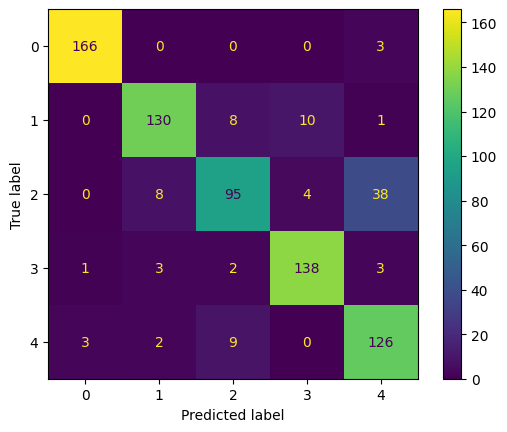

In [27]:
best_model = load('best_stacking.joblib')

# Predicting on the test set using the best model found by RandomizedSearchCV
y_pred = best_model.predict(X_test_preprocessed)

# Calculating and displaying the model's accuracy
print("Accuracy of Stacking:", accuracy_score(y_test, y_pred))

# Generating and displaying the classification report, which includes various evaluation metrics
print("\nClassification Report for Stacking:")
print(classification_report(y_test, y_pred))

# Generating and visualizing the confusion matrix to assess the model's performance in detail
print("\nConfusion Matrix for Stacking:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()